# Exploratory code

The software in this file represents some of our explorations and experiments that were used to make our final analysis.

## Parsing the schema file

In [60]:
import schema
from tabulate import tabulate
from importlib import reload
reload(schema)

schemas = schema.data_schemas_from_file("../data/schema.csv")

In [3]:
for key,value in schemas.items():
    print("#########################################################################")
    print(f"{key} ({value['file pattern']}):")
    print(tabulate(value['fields'],headers='keys'))

#########################################################################
job_events (job_events/part-?????-of-?????.csv.gz):
  field number  content           format       mandatory    formatter
--------------  ----------------  -----------  -----------  ----------------------------------------------------------------
             0  time              INTEGER      True         <function parse_schema_line.<locals>.<lambda> at 0x7f8aecf57eb0>
             1  missing info      INTEGER      False        <function parse_schema_line.<locals>.<lambda> at 0x7f8aecf80a60>
             2  job ID            INTEGER      True         <function parse_schema_line.<locals>.<lambda> at 0x7f8aecf80af0>
             3  event type        INTEGER      True         <function parse_schema_line.<locals>.<lambda> at 0x7f8aecf80b80>
             4  user              STRING_HASH  False        <function parse_schema_line.<locals>.<lambda> at 0x7f8aefd71f30>
             5  scheduling class  INTEGER      False  

## Starting Spark

In [4]:
from pyspark import SparkContext

# start spark with 1 worker thread
sc = SparkContext("local[*]")
sc.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/05 14:02:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/12/05 14:02:40 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Alternate approach with SparkSQL, allowing the use of DataFrames:

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local(*]") \
    .appName("Cluster analysis") \
    .getOrCreate()

## Analysis on machine events

This file describes events that occurred to the machines in the cluster, as well as their specifications (initial events).

First, let us see the schema of this file's data:

In [5]:
print(tabulate(schemas['machine_events']['fields'],headers='keys'))

  field number  content      format       mandatory    formatter
--------------  -----------  -----------  -----------  ----------------------------------------------------------------
             0  time         INTEGER      True         <function parse_schema_line.<locals>.<lambda> at 0x7f8aecf81240>
             1  machine ID   INTEGER      True         <function parse_schema_line.<locals>.<lambda> at 0x7f8aecf81510>
             2  event type   INTEGER      True         <function parse_schema_line.<locals>.<lambda> at 0x7f8aecf81480>
             3  platform ID  STRING_HASH  False        <function parse_schema_line.<locals>.<lambda> at 0x7f8aecf81750>
             4  CPUs         FLOAT        False        <function parse_schema_line.<locals>.<lambda> at 0x7f8aecf81630>
             5  Memory       FLOAT        False        <function parse_schema_line.<locals>.<lambda> at 0x7f8aecf817e0>


### Mahcine Event RDD

In [62]:
machine_events_schema = schemas['machine_events']
machine_events_get = schema.field_getters(machine_events_schema)

machine_events = sc.textFile("../data/machine_events/part-00000-of-00001.csv").map(lambda row: schema.format_row(machine_events_schema, row.split(',')))
machine_events.cache()

for elem in machine_events.take(5):
	print(elem)

[0, 5, 0, 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', 0.5, 0.2493]
[0, 6, 0, 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', 0.5, 0.2493]
[0, 7, 0, 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', 0.5, 0.2493]
[0, 10, 0, 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', 0.5, 0.2493]
[0, 13, 0, 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', 0.5, 0.2493]


### Distribution of CPU usage (Q1)

For the following, we only account for the machine creation events. We note that this method could count a given machine more than once, should it happen to be added more than once (and removed in-between) or modified.

Distribution of machine capacity based on their CPU power:

In [23]:
from operator import add

cpu = schema.index_of_field(machine_events_schema, 'CPUs')
event = schema.index_of_field(machine_events_schema, 'event type')
machine_id = schema.index_of_field(machine_events_schema, 'machine ID')
time = schema.index_of_field(machine_events_schema, 'time')

cpu_usage = machine_events \
    .filter(lambda row: row[event] == 0 and row[cpu] is not None) \
    .map(lambda row: (row[machine_id],row)) \
    .reduceByKey(lambda r1,r2: r1 if r1[time]>r2[time] else r2) \
    .map(lambda row: (row[1][cpu], 1)) \
    .reduceByKey(add)

cpu_usage.foreach(lambda cpu: print(f"{cpu[1]} machines have CPU {cpu[0]}"))

11636 machines have CPU 0.5
123 machines have CPU 0.25
796 machines have CPU 1.0


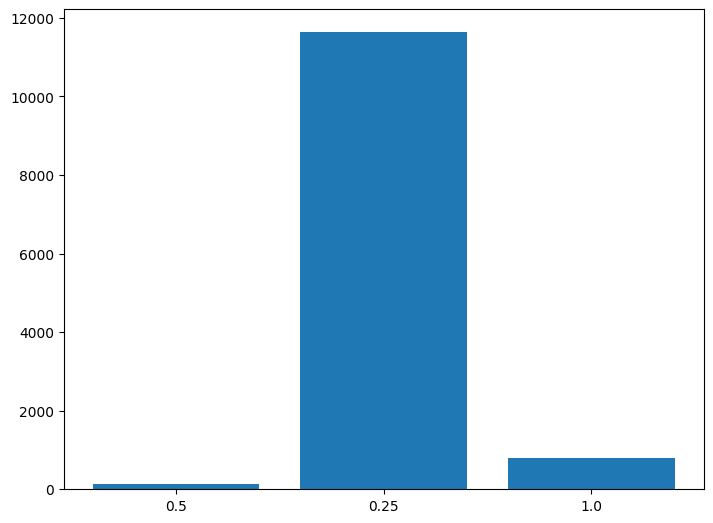

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
legend = cpu_usage.map(lambda x: str(x[0]) if x[0] is not None else 'None').collect()
count = cpu_usage.sortByKey().map(lambda x: x[1]).collect()
ax.bar(legend,count)
plt.show()

### Lost Computational Power

In [38]:
machines_history = machine_events \
    .map(lambda row: (row[machine_id],row)) \
    .aggregateByKey(None,lambda acc, e: acc+[e] if acc is not None else [e],add) \
    .map(lambda machine: machine[1]) \

for e in machines_history.take(10):
    print(tabulate(e))



-  -  -  --------------------------------------------  ---  ------
0  6  0  HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=  0.5  0.2493
-  -  -  --------------------------------------------  ---  ------
-------------  --  -  --------------------------------------------  ---  ------
            0  10  0  HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=  0.5  0.2493
1306164355566  10  1  HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=  0.5  0.2493
1307163081914  10  0  HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=  0.5  0.2493
-------------  --  -  --------------------------------------------  ---  ------
-  --  -  --------------------------------------------  ---  ------
0  14  0  HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=  0.5  0.2493
-  --  -  --------------------------------------------  ---  ------
-------------  --  -  --------------------------------------------  ---  ------
            0  26  0  HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=  0.5  0.2493
 611893094118  26  1  HofLGzk1Or/8I

In [52]:
machines_history.filter(lambda m: sorted(m)).count() - machines_history.count()

0

The trace period starts at 600 seconds (aka $6 \times 10^{8}$ microseconds), to obtain the total trace time, we find the latest event time and subtracted $6 \times 10^{8}$ to it.

In [40]:
from math import ceil

total_trace_time = machine_events.max(lambda row: row[time])[time] - 6*10**8

print(f'The total trace time is {total_trace_time} µs ≈ {ceil(total_trace_time/(10**6 * 3600))} hours ≈ {ceil(total_trace_time/(10**6 * 3600 * 24))} days')

The total trace time is 2505535493517 µs ≈ 696 hours ≈ 29 days


Once we have this number, computing the total computation power of a given machine is a matter of subtracting the starting time of the machine and multiplying by the CPU capacity. We assume here that the CPU capacity of a machine never changes, and we remove the machines that have some cpu values at None to prevent weird events.

In [102]:
def lost_and_total_power(events):
    # Functions and Variables
    status = machine_events_get['event type']
    time = machine_events_get['time']
    start = time(events[0])
    cpu = machine_events_get['CPUs'](events[0])

    # Lost time
    lost_time = 0
    for i,m in enumerate(events):
        if i==0:
            continue
        if status(m)==0 and status(events[i-1])==1:
            lost_time += time(m) - time(events[i-1])
        
    # Total time
    total_time = total_trace_time if (start < 6*10**8) else (total_trace_time - start + 6*10**8)

    # Resulting power
    return (lost_time*cpu,total_time*cpu)

def has_none_cpu(events):
    cpu = machine_events_get['CPUs']
    for m in events:
        if cpu(m) is None:
            return True
    return False

print(f'There are {machines_history.filter(has_none_cpu).count()} machines with None values in their CPUs. They will not be evaluated.')

power_lost_and_total = machines_history.filter(lambda m: not has_none_cpu(m)).map(lost_and_total_power).reduce(lambda p1,p2: (p1[0]+p2[0],p1[1]+p2[1]))
print(f'During the trace time, around {(power_lost_and_total[0]/power_lost_and_total[1])*100:.4f}% of the computational power was lost.\
\nThe exact percentage obtained is {(power_lost_and_total[0]/power_lost_and_total[1])*100}% !')


There are 32 machines with None values in their CPUs. They will not be evaluated.
During the trace time, around 0.4798% of the computational power was lost.
The exact percentage obtained is 0.4798129882918588% !


## Appendix

### With DataFrames

It would be nice to have the tabular methods provided by DataFrames. Fortunately, Spark offers a DataFrame API, through their Spark SQL. To [load a CSV as a DataFrame](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrameReader.csv.html#pyspark.sql.DataFrameReader.csv),

In [ ]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, FloatType, IntegerType, LongType
field_to_spark_type = {
    'time': LongType,
    'machine ID': LongType,
    'event type': IntegerType,
    'platform ID': StringType,
    'CPUs': FloatType,
    'Memory': FloatType
}
machine_events_schema = StructType([
    StructField(field['content'].replace(' ', '_'), field_to_spark_type[field['content']](), field['mandatory']) for field in schemas['machine_events']['fields']
])

machine_events = spark.read \
    .format('csv') \
    .option("header","true") \
    .schema(machine_events_schema) \
    .load("../data/machine_events/part-00000-of-00001.csv")

Let us check that the schema is as we expect

In [ ]:
machine_events.printSchema()

NameError: name 'machine_events' is not defined

And inspect the first few data

In [ ]:
for elem in machine_events.take(5):
	print(elem.asDict())

How much events do we have?

In [ ]:
machine_events.count(), machine_events.filter(machine_events.event_type == 1).count(),machine_events.filter(machine_events.event_type == 2).count()

In [ ]:
machine_events.filter(machine_events.event_type == 0).CPUs